# Counting houses and all that jazz
## Stuff to do 
- [x] Deduplicate
- [x] Filter to only fjernvarme and gas
- [ ] Estimate bolig per building
- [x] Calculate all the distances
- [ ] CHANGE DISTANCE CALCULATIONS TO UTM / EUCLIDIAN
- [ ] FIGURE OUT WHY EVERYONE IS SO CLOSE TO FJERNVARME?????

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
import src.geo_transform as gt
import src.wrangle_bbr as wrangle
from typing import Union

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

In [3]:
DATA_DIR = Path("data")
df = pd.read_csv(DATA_DIR / "select_bbr2.csv")
df = df[~df["koordinat"].isin(['POINT(0 0)', 'POINT(0 0.5)'])]
# make into category
df["bygningens_anvendelse"] = df["bygningens_anvendelse"].astype("category")

C:\Users\jhr\AppData\Local\Temp\ipykernel_2844\4090596968.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "select_bbr2.csv")


In [7]:
df["kvalitet_af_koordinatsæt"].value_counts()

1    2861751
3     124938
2       8608
Name: kvalitet_af_koordinatsæt, dtype: int64

## Filtering to only have gas and fjernvarme
I follow the [official documentation from BBR](https://instruks.bbr.dk/varmeinstallation1/0/30). Here I choose `1` (fjernvarme/blokvarme) and `8` (gas) 

In [6]:
uses_gas = df["opvarmningsmiddel"].isin([2, 7]) | df["varmeinstallation"].isin([8])
uses_fjernvarme = df["varmeinstallation"] == 1
logging.info("%s buildings use gas", uses_gas.sum())
logging.info("%s buildings use fjernvarme", uses_fjernvarme.sum())


2022-06-01 08:35:23,715 - root - INFO - 374966 buildings use gas
2022-06-01 08:35:23,721 - root - INFO - 890037 buildings use fjernvarme


## Getting coords for fjernvarme
- Haversine was totally fucked because of floating point shit
- Euclidean 

In [7]:
cols_to_use  =["husnummer", "koordinat", "kommunekode"]
fjernvarme_koords = df.loc[uses_fjernvarme, cols_to_use].drop_duplicates().dropna()
gas_koords = df.loc[uses_gas, cols_to_use].drop_duplicates().dropna()

In [9]:
gas_coords = gt.points_to_coords(gas_koords["koordinat"]).astype(float)
fjernvarme_coords = gt.points_to_coords(fjernvarme_koords["koordinat"]).astype(float)

In [12]:
df["husnummer"].unique().shape[0]

2018477

In [44]:
gas_lat, gas_long = gt.points_to_wgs84(gas_koords["koordinat"])
fjernvarme_lat, fjernvarme_long = gt.points_to_wgs84(fjernvarme_koords["koordinat"])

In [26]:
print(f"{gas_lat.max() = }")
print(f"{gas_long.max() = }")
print(f"{gas_long.min() = }")
print(f"{gas_lat.min() = }")
print(f"{fjernvarme_lat.max() = }")
print(f"{fjernvarme_long.max() = }")
print(f"{fjernvarme_long.min() = }")
print(f"{fjernvarme_lat.min() = }")

gas_lat.max() = 57.73800683881866
gas_long.max() = 14.749962423627748
gas_long.min() = 8.105017832729311
gas_lat.min() = 54.69872080822638
fjernvarme_lat.max() = 57.73795404356347
fjernvarme_long.max() = 15.150033834562564
fjernvarme_long.min() = 8.109777986434672
fjernvarme_lat.min() = 54.57082859765103


## Testing Euclidean distance

In [10]:
# Euclidian distance with kdtree
from sklearn.neighbors import KDTree

tree = KDTree(fjernvarme_coords, leaf_size=30, metric="euclidean")

# find the closest gas station to each fjernvarme
gas_distances, gas_indices = tree.query(gas_coords, k=1)


In [37]:
close_fjern = fjernvarme_coords.loc[gas_indices.reshape(-1), :].reset_index()

In [16]:
gas_indices

array([[359091],
       [822858],
       [ 17789],
       ...,
       [333375],
       [859326],
       [826257]], dtype=int64)

In [47]:
close_fjernlat = fjernvarme_lat[gas_indices].reshape(-1)
close_fjernlong = fjernvarme_long[gas_indices].reshape(-1)

In [27]:
close_fjernvarme.shape[0] == gas_distances.shape[0] == gas_koords.shape[0] == gas_coords.shape[0]

True

In [11]:
SHORT_DIST = 500
LONG_DIST = 1000

short_gas = (gas_distances < SHORT_DIST).sum()
medium_gas = ((LONG_DIST > gas_distances) & (gas_distances > SHORT_DIST)).sum()
long_gas = (gas_distances > LONG_DIST).sum()
logging.info("%s buildings are more short distance out of %s buildings", short_gas,  gas_distances.shape[0])
logging.info("%s buildings are more short distance out of %s buildings", medium_gas,  gas_distances.shape[0])
logging.info("%s buildings are more short distance out of %s buildings", long_gas,  gas_distances.shape[0])

2022-05-23 09:23:25,334 - root - INFO - 254061 buildings are more short distance out of 374562 buildings
2022-05-23 09:23:25,335 - root - INFO - 57004 buildings are more short distance out of 374562 buildings
2022-05-23 09:23:25,336 - root - INFO - 63497 buildings are more short distance out of 374562 buildings


In [38]:
gas_koords

husnummer                    koordinat
0        0a3f5090-a68c-32b8-e044-0003ba298018  POINT(516612.96 6142758.59)
1        0a3f507d-a4b9-32b8-e044-0003ba298018  POINT(721498.37 6192612.49)
3        0a3f5094-0318-32b8-e044-0003ba298018  POINT(557868.43 6254433.17)
14       0a3f508f-7e22-32b8-e044-0003ba298018  POINT(543759.35 6182600.29)
17       0a3f5082-3f88-32b8-e044-0003ba298018  POINT(703438.09 6158525.48)
...                                       ...                          ...
1265030  0a3f5093-d578-32b8-e044-0003ba298018        POINT(551073 6237512)
1265032  0a3f5082-4647-32b8-e044-0003ba298018   POINT(702510.07 6157716.9)
1265039  0a3f5090-a2ca-32b8-e044-0003ba298018  POINT(524420.18 6139971.93)
1265042  0a3f5094-3456-32b8-e044-0003ba298018    POINT(568181.8 6268750.2)
1265043  0a3f5092-fe1f-32b8-e044-0003ba298018  POINT(476884.55 6214272.44)

[374562 rows x 2 columns]

In [ ]:

pd.DataFrame({
    "ID": gas_koords["husnummer"], 
    "kommunekode": gas_koords["kommunekode"],
    "gas_lat": gas_lat.reshape(-1), 
    "gas_long": gas_long.reshape(-1), 
    "distance": gas_distances.reshape(-1),
    "fjernvarme_lat": close_fjernlat,
    "fjernvarme_long": close_fjernlong, 
}).to_csv(DATA_DIR / "gas_fjernvarme_distances.csv", index=False)

In [30]:
gas_distances[:, 0].shape

(374562,)

In [36]:

output_df = pd.DataFrame({
    "ID": gas_koords["husnummer"].reset_index(drop=True),
    "kommunekode": gas_koords["kommunekode"].reset_index(drop=True),
    "gas_x": gas_coords["x"], 
    "gas_y": gas_coords["y"], 
    "distance": gas_distances[:, 0],
    "fjernvarme_x": close_fjern["x"],
    "fjernvarme_y": close_fjern["y"], 
})#

output_df
#
# .to_csv(DATA_DIR / "gas_fjernvarme_xy.csv", index=False)

ID  kommunekode      gas_x  \
0       0a3f5090-a68c-32b8-e044-0003ba298018          621  516612.96   
1       0a3f507d-a4b9-32b8-e044-0003ba298018          230  721498.37   
2       0a3f5094-0318-32b8-e044-0003ba298018          730  557868.43   
3       0a3f508f-7e22-32b8-e044-0003ba298018          766  543759.35   
4       0a3f5082-3f88-32b8-e044-0003ba298018          269  703438.09   
...                                      ...          ...        ...   
374557  0a3f5093-d578-32b8-e044-0003ba298018          710  551073.00   
374558  0a3f5082-4647-32b8-e044-0003ba298018          269  702510.07   
374559  0a3f5090-a2ca-32b8-e044-0003ba298018          621  524420.18   
374560  0a3f5094-3456-32b8-e044-0003ba298018          730  568181.80   
374561  0a3f5092-fe1f-32b8-e044-0003ba298018          760  476884.55   

             gas_y     distance  
0       6142758.59   182.048449  
1       6192612.49   221.696775  
2       6254433.17   439.560751  
3       6182600.29   733.776056  
4       6158525.48    62.081472  
...            ...          ...  
374557  6237512.00   555.152745  
374558  6157716.90    91.571024  
374559  6139971.93  3603.517402  
374560  6268750.20   145.543761  
374561  6214272.44   936.257890  

[374562 rows x 5 columns]

In [14]:
pd.DataFrame({
    "ID": gas_koords["husnummer"], 
    "lat": gas_lat.reshape(-1), 
    "long": gas_long.reshape(-1), 
    "distance": gas_distances.reshape(-1), 
}).to_csv("out/gas_distances.csv", index=False)

In [14]:
df["husnummer"].drop_duplicates().shape

(2018477,)

In [15]:
fjernvarme_coords.shape[0]

888315

In [28]:
gas_distances.max()

49167.29290311298

<AxesSubplot:>

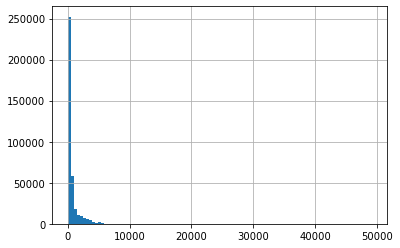

In [29]:
pd.Series(gas_distances.reshape(-1)).hist(bins=100)

In [12]:
from sklearn.neighbors import BallTree

tree = BallTree(fjernvarme_latlon, metric="haversine")
distances, indices = tree.query(gas_latlon, k=1)

In [18]:
earth_radius_m = 6371000
distances_m = distances * earth_radius_m
distances.min()

0.0

In [19]:
indices

array([[359091],
       [822858],
       [ 17789],
       ...,
       [333375],
       [859326],
       [826257]], dtype=int64)

In [12]:
assert gas_dists.shape[0] == gas_arr.shape[0]
assert gas_dists.shape[1] == fjernvarme_latlon.shape[0]

In [22]:
#gaslat, gaslong = gt.points_to_wgs84(gas_koords["koordinat"])
gasx, gasy = gt.get_xy_from_points(gas_koords["koordinat"])
fjernvarme_x, fjernvarme_y = gt.get_xy_from_points(fjernvarme_koords["koordinat"])

In [26]:
na_idx = fjernvarme_x.argmin()

fjernvarme_koords["koordinat"].values[na_idx]

'POINT(0 0.5)'

In [15]:
na_idxs = gasx.argmin()

gas_koords["koordinat"].values[na_idxs]

'POINT(0 0)'

In [14]:
df["koordinatsystem"].dropna().unique()

array(['5'], dtype=object)

In [22]:
print(df.shape)
df["varmeinstallation"].value_counts()

(3079428, 10)


1     898015
9     890933
2     696586
7     327417
5     193114
3      51145
6      20640
99       794
8        784
Name: varmeinstallation, dtype: int64